In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
# Ajoutez le chemin du dossier parent à la variable d'environnement PYTHONPATH
parent_path = os.path.abspath(r"\Users\jloya\Documents\1-week-1-bot-challenge\6. CODES\FEATURES")
sys.path.append(parent_path)
from FeaturesLibrary import *
from Signals import *
from FeaturesImportance import *

# Data Import

In [7]:
# Import the data
ethusd = pd.read_csv(r"..\DATA\4-hours Pepperstone\4-hours_ETHUSD.csv", parse_dates=True, index_col="time").iloc[0:5000,:]


# Target Engineering

In [8]:
ethusd["time"] = ethusd.index
ethusd["time"] = ethusd["time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
ethusd = get_barrier(ethusd, tp=.0075, sl=-.0050, buy=True)



100%|██████████| 5000/5000 [00:00<00:00, 11214.87it/s]


In [9]:
def dummy_labeling(df):
    df_copy = df.copy()
    
    df_copy["dummy"] = -1
    df_copy.loc[df_copy["labeling"]<0, "dummy"] = 0
    df_copy.loc[0<df_copy["labeling"], "dummy"] = 1
    
    df_copy = df_copy[df_copy["dummy"]!=-1]
    
    return df_copy

In [10]:
ethusd = dummy_labeling(ethusd)

In [11]:
print(len(ethusd))

4415


# Features Engineering

In [12]:
def create_features(df):
    df = rolling_adf(df, "close", window_size=30)
    df = DC_market_regime(df, 0.015)
    df = spread(df)
    df = kama_market_regime(df, "close", 60, 200)
    df = gap_detection(df)
    df = displacement_detection(df)
    for i in [1,2,5,10,20,50]:
        df = auto_corr(df, "close", n=50, lag=i)
        df = log_transform(df, "close", i)
    df = derivatives(df,"close")
    df = candle_information(df)
    df = moving_yang_zhang_estimator(df, 200)
    df = moving_parkinson_estimator(df,30)
    
    return df

ethusd = create_features(ethusd.iloc[:-1,:])



c:\Users\jloya\Documents\1-week-1-bot-challenge\6. CODES\FEATURES\FeaturesLibrary.py:313: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_dc_price = df["close"][0]
c:\Users\jloya\Documents\1-week-1-bot-challenge\6. CODES\FEATURES\FeaturesLibrary.py:428: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy["market_regime"] = df_copy["market_regime"].fillna(method="ffill")
c:\Users\jloya\Documents\1-week-1-bot-challenge\6. CODES\FEATURES\FeaturesLibrary.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  "Bearish_gap_sup", "Bearish_gap_inf"]].fillna(method="ffill")
c:\Users\jloya\Documents\1-week-1-bot-challenge\6. CODE

# Train/Test

In [13]:
ethusd_train = ethusd.iloc[:3000,:]
ethusd_test = ethusd.iloc[3000:,:]

# Features - Target Building

In [14]:
list_X = ["velocity", "acceleration", "candle_way", "filling", "spread", "tick_volume",
          'ret_log_1', 'ret_log_2', 'ret_log_5', 'ret_log_10',
       'ret_log_20', 'ret_log_50', 'autocorr_1', 'autocorr_2', 'autocorr_5',
       'autocorr_20',"autocorr_10", "kama_diff",
          "amplitude","rolling_volatility_yang_zhang", "rolling_volatility_parkinson",
         "kama_trend", "rolling_adf_stat"]
col_y = "dummy"

# Correlation

In [15]:
# Make a copy of the dataframe and drop rows with NA values
correlations = []
assets = [ethusd]
for asset in assets:
    df_copy = asset[list_X + [col_y]].dropna()

    # Create feature matrix X and target vector y
    X = df_copy[list_X].iloc[:-1,:]
    y = df_copy[col_y].iloc[1:]

    dfc = pd.concat((X,y), axis=1)

    correlations.append(dfc.corr()[col_y])

In [19]:
dfc.head()

,velocity,acceleration,candle_way,filling,spread,tick_volume,ret_log_1,ret_log_2,ret_log_5,ret_log_10,...,autocorr_5,autocorr_20,autocorr_10,kama_diff,amplitude,rolling_volatility_yang_zhang,rolling_volatility_parkinson,kama_trend,rolling_adf_stat,dummy
time,,,,,,,,,,,,,,,,,,,,,
2018-08-20 04:00:00,-3.00,-2.50,-1.0,0.448276,7.25,478.0,-0.001773,-0.002066,-0.000594,0.008606,...,0.839047,0.208323,0.638166,8.428081,1.093853,0.016950,0.027669,1.0,-2.794197,NaN
2018-08-20 08:00:00,-6.75,-3.75,-1.0,0.650000,10.00,753.0,-0.004062,-0.005828,-0.005242,0.000153,...,0.828798,0.080924,0.618963,8.355200,2.226104,0.016990,0.027845,1.0,-0.945418,1.0
2018-08-20 20:00:00,-4.75,2.00,-1.0,0.640000,6.25,691.0,-0.002928,-0.006978,-0.007568,-0.001086,...,0.818724,-0.004231,0.592500,8.605405,1.398650,0.016935,0.027503,1.0,-0.895052,0.0
2018-08-21 00:00:00,-11.50,-6.75,-1.0,0.674118,17.00,1265.0,-0.007318,-0.010224,-0.016281,-0.010073,...,0.805551,-0.081502,0.562803,9.668471,4.119042,0.017083,0.028249,1.0,-0.892141,0.0
2018-08-21 04:00:00,1.00,12.50,1.0,0.300000,2.50,474.0,0.000653,-0.006669,-0.015349,-0.004798,...,0.799222,-0.212199,0.532351,10.539479,0.274610,0.017049,0.028247,1.0,-2.619605,1.0


In [20]:
correlation = pd.concat(correlations, axis=1)
correlation.columns = ["ETHUSD"]
correlation = correlation.transpose()
del correlation[col_y]
#correlation = correlation.transpose()

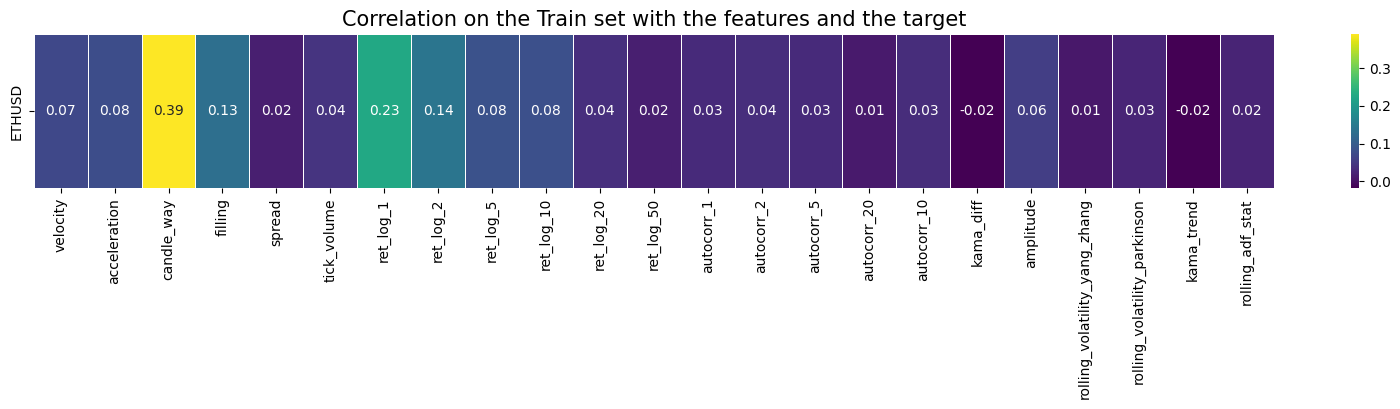

In [21]:
plt.figure(figsize=(20, 2))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
plt.title("Correlation on the Train set with the features and the target", size=15)
plt.show()

In [22]:
list_X = ["velocity", "candle_way", "filling", "spread",
          'ret_log_1', 'ret_log_2', 'ret_log_5', 'ret_log_50','autocorr_5',
        "kama_diff",
          "amplitude","rolling_volatility_yang_zhang", "rolling_volatility_parkinson",
         "market_regime", "kama_trend"]

# Features Importance

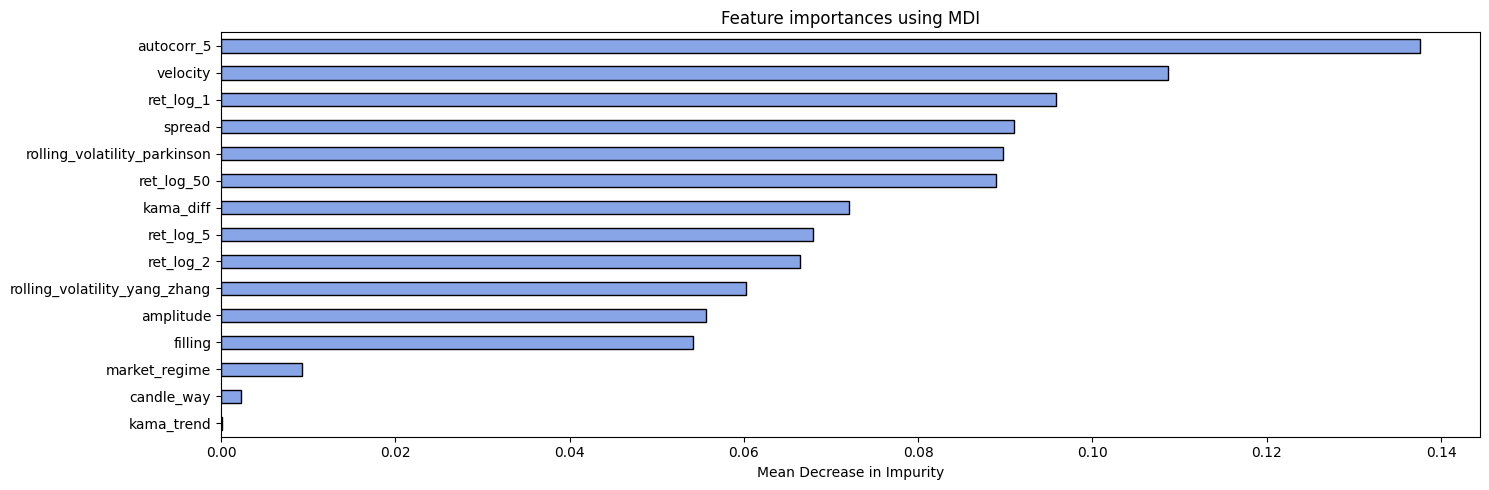

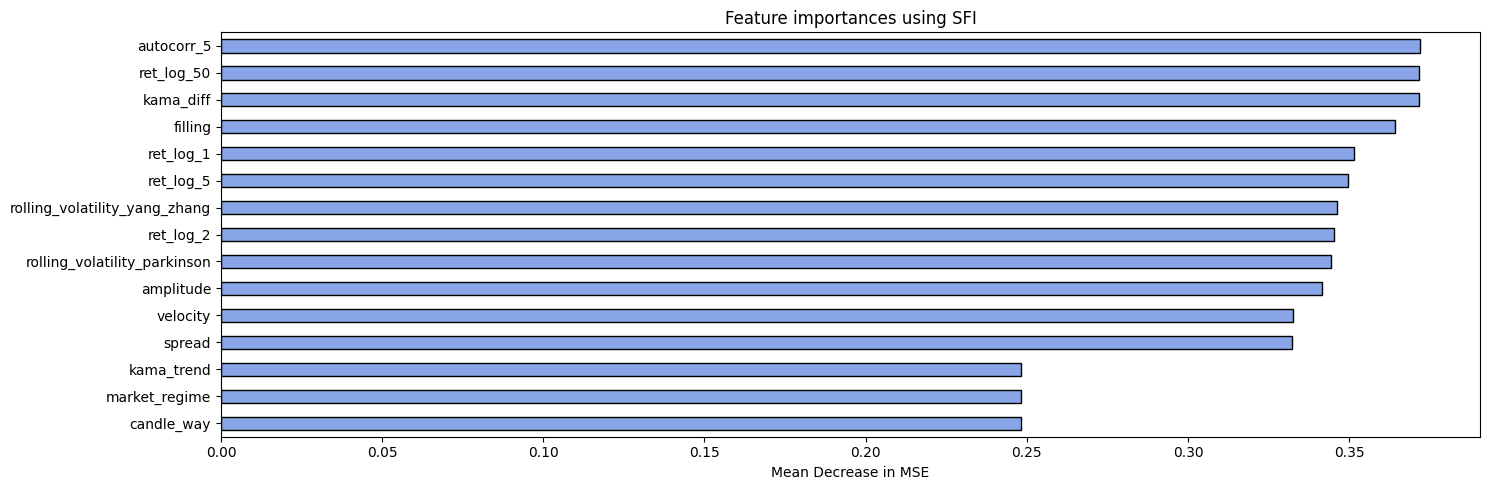

In [23]:
feature_importance(ethusd, list_X, col_y, reg=False, mda=False)

# Model

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [26]:
#df = pd.concat((eurusd_train, gbpusd_train, usdcad_train), axis=0)
df = ethusd
# Make a copy of the dataframe and drop rows with NA values
df_copy = df[list_X + [col_y]].dropna()
df_copy = df_copy[~np.isinf(df_copy).any(axis=1)]

# Create feature matrix X and target vector y
X = df_copy[list_X].iloc[:-1,:].values
y = df_copy[col_y].iloc[1:].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a RandomForest model
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
y_pred = model.predict(X_test)

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calcul de l'accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}")

# Calcul du score F1
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[354 107]
 [280 102]]

Accuracy: 0.5409
F1 Score: 0.3452


In [29]:
97/(97+123)

0.4409090909090909

# Robustness

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

def plot_timeseries_cv_indices(cv, X, y, ax, n_splits, lw=5):
    """Visualize results of TimeSeriesSplit."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        
        # Visualize the training and test sets
        ax.scatter(range(len(indices)), [ii + 0.5] * len(indices),
                   c=indices, marker="_", lw=lw, cmap='coolwarm_r', vmin=-0.2, vmax=1.2)
        
    # Visualize the targets
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker="_", lw=lw*6, cmap='RdYlGn', vmin=0, vmax=1)

    # Format the plot
    yticklabels = list(range(n_splits)) + ['target']
    ax.set(yticks=np.arange(n_splits + 1) + 0.5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel='CV iteration', 
           ylim=[n_splits + 1.6, -0.1], xlim=[0, len(X)])
    ax.set_title('TimeSeriesSplit', fontsize=15)
    return ax

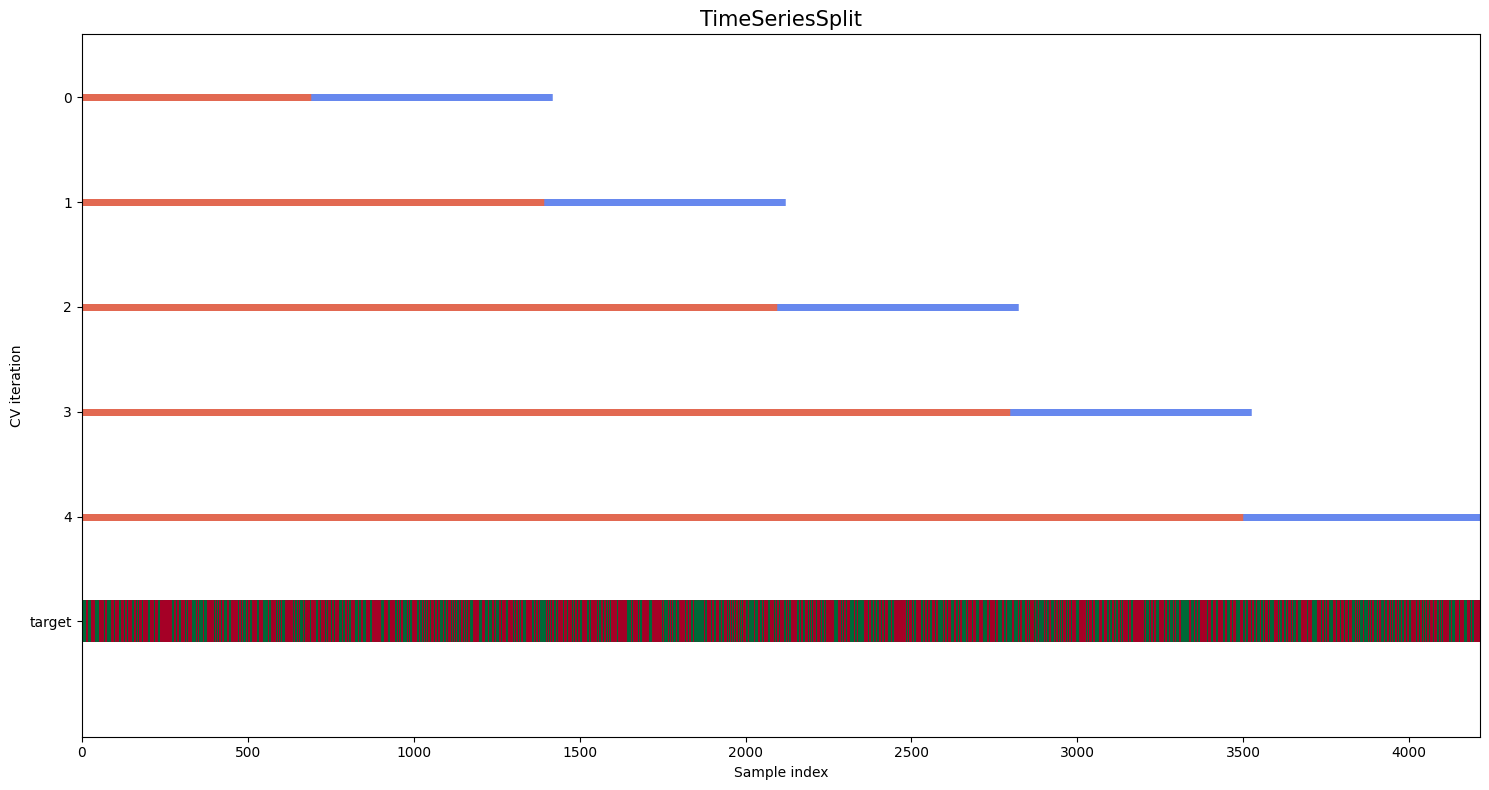

In [31]:
# Create the TimeSeriesSplit object
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Visualize the results
fig, ax = plt.subplots(figsize=(15, 8))
plot_timeseries_cv_indices(tscv, X, y, ax, n_splits)
plt.tight_layout()
plt.show()

In [32]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, TimeSeriesSplit

df=ethusd

# Make a copy of the dataframe and drop rows with NA values
df_copy = df[list_X + [col_y]].dropna()
df_copy = df_copy[~np.isinf(df_copy).any(axis=1)]

# Create feature matrix X and target vector y
X = df_copy[list_X].iloc[:-1,:].values
y = df_copy[col_y].iloc[1:].values

# Initialize classifier
clf = RandomForestClassifier(random_state=42)

# K-Fold cross validation
tscv = TimeSeriesSplit(n_splits=5)
#kf = KFold(n_splits=k, shuffle=False)

# Collect scores
scores = cross_val_score(clf, X, y, cv=tscv, scoring="precision")

print(f"Scores for each fold: {scores}")
print(f"Average Precision: {np.mean(scores):.2f}")
print(f"Standard Deviation: {np.std(scores):.2f}")


Scores for each fold: [0.50285714 0.42045455 0.41621622 0.44791667 0.39269406]
Average Precision: 0.44
Standard Deviation: 0.04


# WARNINGS

Very good accuracy but BE CAREFUL, the acccuracy doesn't mean anything for us. We need to know the HIT ratio when we enter in position
